In [256]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

import nimfa
from sklearn.decomposition import NMF
from scipy.cluster.vq import vq, kmeans, kmeans2, whiten
from scipy.fftpack import ifft
import librosa
import IPython
from IPython.display import Audio

def make_sinewave(f, t, sr):
    x = np.linspace(0, t, t*sr)
    y = np.sin(2*np.pi*f*x)
    return y

def mag_spectogram(X):
    "Computes Spectogram from the stft."
    Nf, Nt = X.shape
    V = np.abs(X[:(Nf/2)+1])
    return V

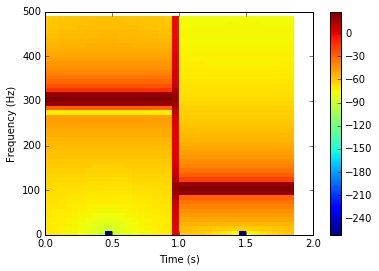

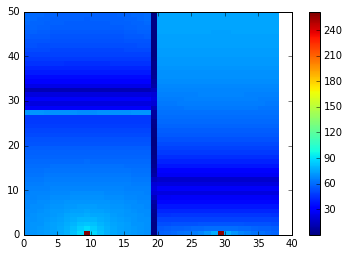

In [238]:
V = np.array(
    [[5,3,0,1],
     [4,0,0,1],
     [1,1,0,5],
     [1,0,0,4],
     [0,1,5,4]])

sr = 1000
signal = np.concatenate((make_sinewave(300, 1, sr), make_sinewave(100, 1, sr)))
sgram, times, freqs = spectrogram(signal, 100, 50, sr)
plt.pcolormesh(np.abs(sgram))
plt.colorbar();

[1 0 0 0 0 0 0 0 0 0]


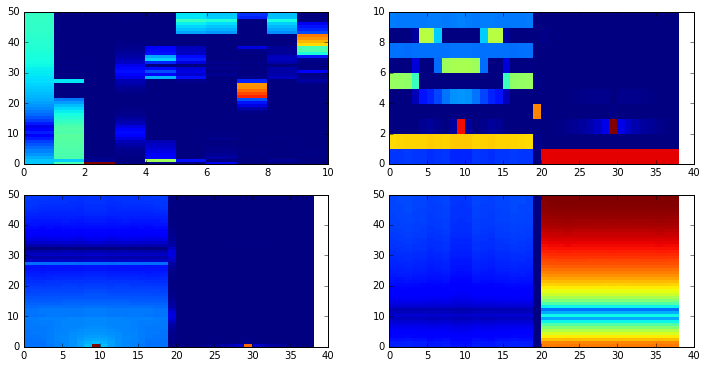

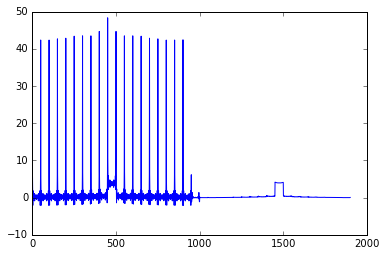

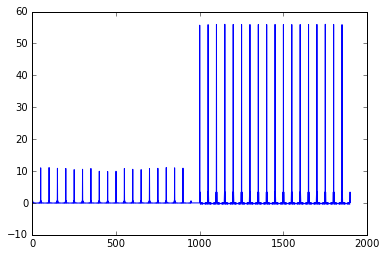

In [139]:
V = np.abs(sgram)
nmf = nimfa.Nmf(V, seed="nndsvd", rank=10, max_iter=5000, update='euclidean', objective='fro')
nmf_fit = nmf()
W = np.array(nmf_fit.basis())
H = np.array(nmf_fit.coef())
V_nimfa = np.dot(W, H)

data = whiten(H)
centroids, _ = kmeans(data, 2)
idx, _ = vq(data, centroids)
print idx

W1, H1 = W[:, idx == 0], H[idx == 0, :]
W2, H2 = W[:, idx == 1], H[idx == 1, :]

plt.figure(figsize=(12,6)) 
plt.subplot(221)
plt.pcolormesh(W)
plt.subplot(222)
plt.pcolormesh(H)

plt.subplot(223)
V1 = np.dot(W1, H1)
plt.pcolormesh(V1)

plt.subplot(224)
V2 = np.dot(W2, H2)
plt.pcolormesh(V2)
plt.show()

x1 = istft(V1, 50).real
x2 = istft(V2, 50).real
plt.plot(x1), plt.show();
plt.plot(x2), plt.show();

[1 0 1 1 0 0 1 1 1 0]


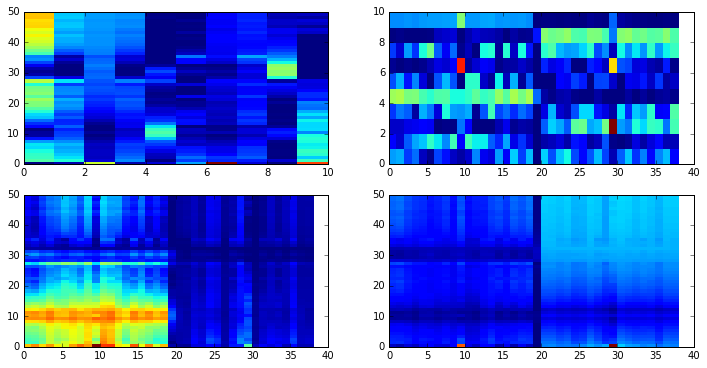

In [87]:
model = NMF(n_components=10, init='random', random_state=0)
W = model.fit_transform(V) 
H = model.fit(V).components_
V_sklearn = np.dot(W, H)

data = whiten(H)
centroids, _ = kmeans(data, 2)
idx, _ = vq(data, centroids)
print idx

W1, H1 = W[:, idx == 0], H[idx == 0, :]
W2, H2 = W[:, idx == 1], H[idx == 1, :]

plt.figure(figsize=(12,6)) 
plt.subplot(221)
plt.pcolormesh(np.array(W))
plt.subplot(222)
plt.pcolormesh(np.array(H))

plt.subplot(223)
V1 = np.dot(W1, H1)
plt.pcolormesh(np.array(V1))

plt.subplot(224)
V2 = np.dot(W2, H2)
plt.pcolormesh(np.array(V2));

(1025, 1290)


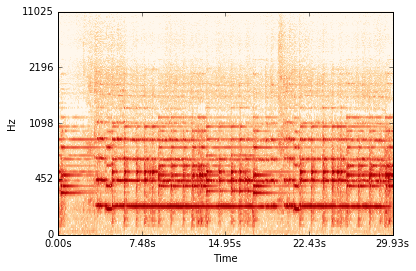

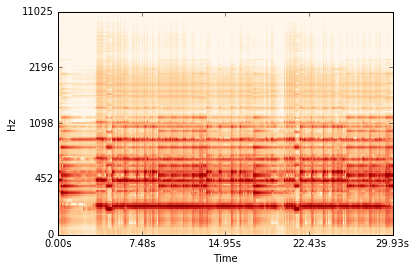

[1 0 0 0 0 0 0 0 0 0]


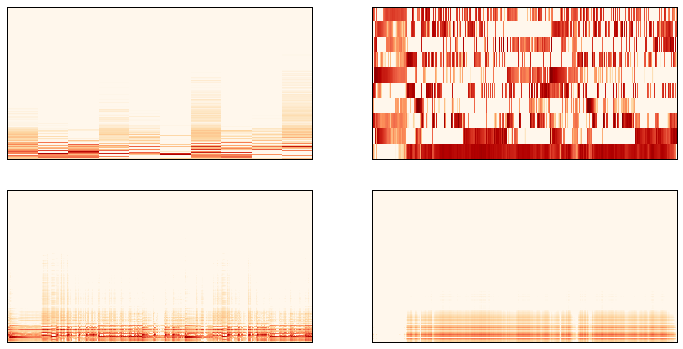

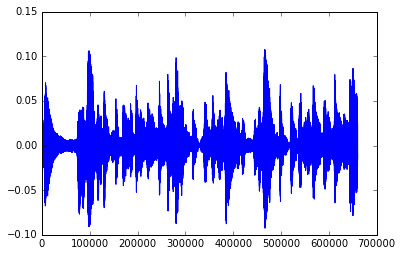

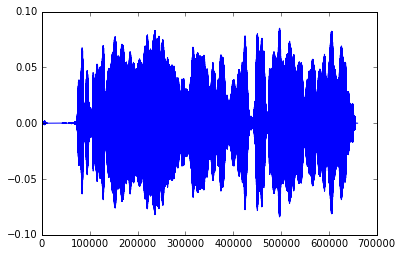

In [207]:
signal, sr = librosa.load('mix.wav', sr=44100., duration=30)
sgram = librosa.stft(signal)
librosa.display.specshow(librosa.logamplitude(np.abs(sgram)**2, ref_power=np.max), y_axis='log', x_axis='time')
plt.show()

V = np.abs(sgram)
phi = np.angle(sgram)

nmf = nimfa.Nmf(V, seed="nndsvd", rank=10, max_iter=50, update='euclidean', objective='fro')
nmf_fit = nmf()
W = np.array(nmf_fit.basis())
H = np.array(nmf_fit.coef())
V_nimfa = np.dot(W, H) * np.exp(1j * phi)
librosa.display.specshow(librosa.logamplitude(V_nimfa**2, ref_power=np.max), y_axis='log', x_axis='time')
plt.show()

data = whiten(H)
centroids, _ = kmeans(data, 2)
idx, _ = vq(data, centroids)
print idx

W1, H1 = W[:, idx == 0], H[idx == 0, :]
W2, H2 = W[:, idx == 1], H[idx == 1, :]

plt.figure(figsize=(12,6)) 
plt.subplot(221)
librosa.display.specshow(librosa.logamplitude(W**2, ref_power=np.max))
plt.subplot(222)
librosa.display.specshow(librosa.logamplitude(H**2, ref_power=np.max))

plt.subplot(223)
V1 = np.dot(W1, H1)
librosa.display.specshow(librosa.logamplitude(V1**2, ref_power=np.max))

plt.subplot(224)
V2 = np.dot(W2, H2)
librosa.display.specshow(librosa.logamplitude(V2**2, ref_power=np.max))
plt.show()

x1 = librosa.istft(V1)
x2 = librosa.istft(V2)
x_nimfa = librosa.istft(V_nimfa)
plt.plot(x1), plt.show()
plt.plot(x2), plt.show()

IPython.display.display(Audio(x1, rate=sr))
IPython.display.display(Audio(x2, rate=sr))
IPython.display.display(Audio(x_nimfa, rate=sr))

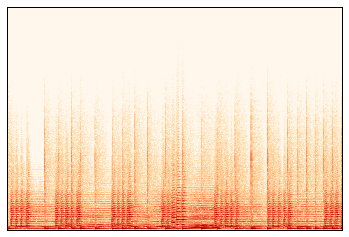

[(0, 0), (1, 1), (2, 1), (3, 2), (4, 2), (5, 1), (6, 2), (7, 1), (8, 2), (9, 2), (10, 0), (11, 2), (12, 1), (13, 2), (14, 1)]


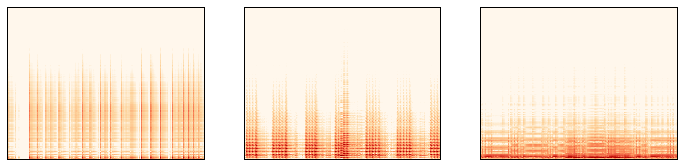

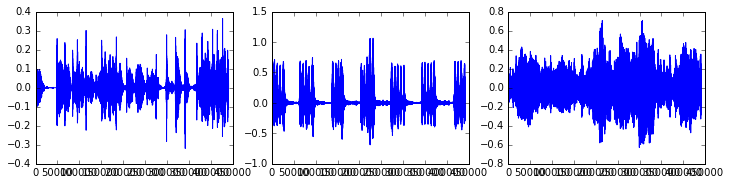

In [412]:
def nmf(V, k, precision = 0.001, max_iters = 100):
    m, n = V.shape
    W, H = 1 + np.random.rand(m, k), 1 + np.random.rand(k, n)
    ones = np.ones(V.shape)
    eps = np.finfo(V.dtype).eps
    iters = 0
    
    while np.linalg.norm(V - np.dot(W, H)) / (V.size) > precision and iters < max_iters:
        W = W * np.dot(V / np.dot(W, H), H.T) / (np.dot(ones, H.T) + eps)
        H = H * np.dot(W.T, V / np.dot(W, H)) / (np.dot(W.T, ones) + eps)
        iters += 1
        
    # normalize W to sum to 1
    sumW = np.sum(W)
    diag1 = np.zeros((k, k))
    diag2 = np.zeros((k, k))
    np.fill_diagonal(diag1, 1. / sumW)
    np.fill_diagonal(diag2, sumW)
    W = np.dot(W, diag1)
    H = np.dot(diag2, H)
    return W, H

def filter_nmf(W, H, phi, s):
    n, k = W.shape
    _, m = H.shape
    X = []
    features = []
    
    # reconstruct each basis as a separate source
    for i in xrange(k):
#         print "Audio: %d" % i
        W_i, H_i = W[:,i].reshape((n, 1)), H[i,:].reshape((1, m))
        V_i = np.dot(W_i, H_i)
        
        # Multiply with phase
        V_i = V_i * np.exp(1j * phi)
        x_i = librosa.istft(V_i)
        X.append(x_i)
        
        # calculate mfcc features
        mfccs = librosa.feature.mfcc(y=x_i, sr=sr)
        mfccs = (mfccs - mfccs.mean(axis=0)) / mfccs.std(axis=0)
        stats = np.concatenate((np.mean(mfccs, axis=1), np.std(mfccs, axis=1)))
        #stats = np.std(mfccs, axis=1)[0]
        features.append(stats)
        
#         print "avg: %r" % np.mean(mfccs, axis=1)
#         print "std: %r" % np.std(mfccs, axis=1)
        
        # plot
#         plt.figure(figsize=(12, 4)) 
#         plt.subplot(121)
#         librosa.display.specshow(librosa.logamplitude(V_i**2, ref_power=np.max))
#         plt.subplot(122)
#         librosa.display.specshow(mfccs, x_axis='time')
#         plt.show()
#         IPython.display.display(Audio(x_i, rate=sr))
        
    features = whiten(np.array(features))
    centroids, _ = kmeans(features, s)
    idx, _ = vq(features, centroids)
    print zip(range(len(idx)), idx)
    return np.array(X), idx


# load audio

drums, sr = librosa.load('input/drums_original.wav', sr=44100., duration=10, mono=True)
electricpiano, sr = librosa.load('input/electricpiano_original.wav', sr=44100., duration=10, mono=True)
percussion, sr = librosa.load('input/percussion_original.wav', sr=44100., duration=10, mono=True)
piano, sr = librosa.load('input/piano_original.wav', sr=44100., duration=10, mono=True)
strings, sr = librosa.load('input/strings_original.wav', sr=44100., duration=10, mono=True)
trumpet, sr = librosa.load('input/trumpet_original.wav', sr=44100., duration=10, mono=True)
violin, sr = librosa.load('input/violin_original.wav', sr=44100., duration=10, mono=True)
signal = drums + trumpet + strings

# STFT and mag spectogram
sgram = librosa.stft(signal)
V = np.abs(sgram)
phi = np.angle(sgram)
librosa.display.specshow(librosa.logamplitude(V**2, ref_power=np.max))
plt.show()

W, H = nmf(V, 15)
V_nmf = np.dot(W, H) * np.exp(1j * phi)
X, idx = filter_nmf(W, H, phi, 3)

W1, H1 = W[:, idx == 0], H[idx == 0, :]
W2, H2 = W[:, idx == 1], H[idx == 1, :]
W3, H3 = W[:, idx == 2], H[idx == 2, :]
V1 = np.dot(W1, H1) * np.exp(1j * phi)
V2 = np.dot(W2, H2) * np.exp(1j * phi)
V3 = np.dot(W3, H3) * np.exp(1j * phi)

x1 = librosa.istft(V1)
x1 = np.concatenate((x1, np.zeros(signal.size - x1.size)))
x2 = librosa.istft(V2)
x2 = np.concatenate((x2, np.zeros(signal.size - x2.size)))
x3 = librosa.istft(V3)
x3 = np.concatenate((x3, np.zeros(signal.size - x3.size)))

plt.figure(figsize=(12,6)) 
plt.subplot(231)
librosa.display.specshow(librosa.logamplitude(V1**2, ref_power=np.max))
plt.subplot(232)
librosa.display.specshow(librosa.logamplitude(V2**2, ref_power=np.max))
plt.subplot(233)
librosa.display.specshow(librosa.logamplitude(V3**2, ref_power=np.max))
plt.show()

plt.figure(figsize=(12,6)) 
plt.subplot(231)
plt.plot(x1)
plt.subplot(232)
plt.plot(x2)
plt.subplot(233)
plt.plot(x3)
plt.show()

IPython.display.display(Audio(x1, rate=sr))
IPython.display.display(Audio(x2, rate=sr))
IPython.display.display(Audio(x3, rate=sr))

librosa.output.write_wav('output/drums_trumpet_strings/mix.wav', signal, sr)
librosa.output.write_wav('output/drums_trumpet_strings/drums_recovered.wav', x1, sr)
librosa.output.write_wav('output/drums_trumpet_strings/trumpet_recovered.wav', x2, sr)
librosa.output.write_wav('output/drums_trumpet_strings/strings_recovered.wav', x3, sr)

In [398]:
reference_sources = np.array([piano, violin])
estimated_sources = np.array([x1, x2])
scores = bss_eval_sources(reference_sources, estimated_sources)
pprint(scores)
pprint(np.mean(scores, axis=1))

(array([ 12.0744014,   9.1111375]),
 array([ 14.49458315,  13.93698574]),
 array([ 15.91941342,  11.01696025]),
 (0, 1))
array([ 10.59276945,  14.21578444,  13.46818684,   0.5       ])


In [369]:
reference_sources = np.array([piano, violin, percussion])
estimated_sources = np.array([x1, x2, x3])
scores = bss_eval_sources(reference_sources, estimated_sources)
pprint(scores)
pprint(np.mean(scores, axis=1))

(array([ 10.03484129,  -3.26167531,  -0.17941569]),
 array([ 12.21506901,  -1.34057044,   4.98429352]),
 array([ 14.32552275,   4.93796527,   2.5948851 ]),
 (0, 1, 2))
array([ 2.19791676,  5.28626403,  7.28612437,  1.        ])
